In [1]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import random
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()


In [3]:
import random

# Kamus Sinonim lebih lengkap
AUG_SYNONYM = {
    "bagus": ["baik", "mantap", "oke", "keren"],
    "buruk": ["jelek", "parah", "tidak bagus", "kurang"],
    "error": ["bug", "masalah", "kendala"],
    "crash": ["force close", "tutup sendiri"],
    "lemot": ["lambat", "slow", "lelet"],
    "lambat": ["lemot", "slow"],
    "cepat": ["kilat", "langsung", "gesit"],
    "loading": ["memuat", "proses"],
    "fitur": ["feature", "menu", "fungsi"],
    "update": ["pembaruan", "upgrade"],
    "login": ["masuk", "sign in"],
    "logout": ["keluar", "sign out"],
    "akun": ["account", "profil"],
    "otp": ["kode verifikasi", "kode keamanan", "verification code"],
    "kode": ["OTP", "security code"],
    "layanan": ["service", "pelayanan"],
    "aplikasi": ["app", "platform", "software"],
    "susah": ["ribet", "rumit"],
    "mudah": ["simple", "gampang"],
    "gagal": ["tidak berhasil", "failed"],
    "berhasil": ["sukses", "ok"],
    "tidak": ["ga", "nggak"],
}


def synonym_replacement(text, p=0.25):
    words = text.split()
    if len(words) < 2:
        return text
    
    new_words = []
    for w in words:
        # jika ada di kamus sinonim dan probabilitas terpenuhi
        if w.lower() in AUG_SYNONYM and random.random() < p:
            new_words.append(random.choice(AUG_SYNONYM[w.lower()]))
        else:
            new_words.append(w)

    return " ".join(new_words)


def augment_text(text, p=0.25):
    outputs = []
    outputs.append(synonym_replacement(text, p))
    return outputs


In [4]:
df = pd.read_csv("data_prelabeled_full.csv")

df = df.dropna(subset=['aspect', 'context', 'polaritas'])

df['aspect_clean'] = df['aspect'].apply(clean_text)
df['context_clean'] = df['context'].apply(clean_text)

df['polaritas'] = df['polaritas'].str.lower().str.strip()

label_map = {'negatif':0, 'negative':0, 'netral':1, 'neutral':1, 'positif':2, 'positive':2}
inv_label_map = {0:'negatif', 1:'netral', 2:'positif'}

df['label'] = df['polaritas'].map(label_map)
df['text'] = df['aspect_clean'] + " [SEP] " + df['context_clean']
df = df[df['text'].str.strip() != ""]

print("\n" + "="*80)
print("CONTOH FORMAT INPUT DENGAN ASPEK")
print("="*80)
print("\nDengan format ini, model akan belajar bahwa:")
print("- Bagian SEBELUM [SEP] = aspek yang harus dianalisis")
print("- Bagian SETELAH [SEP] = konteks kalimat")
print("\nContoh data:")

for i in range(5):
    if i < len(df):
        print(f"\n[{i+1}] Aspek Asli: {df.iloc[i]['aspect']}")
        print(f"    Konteks Asli: {df.iloc[i]['context'][:60]}...")
        print(f"    ➜ Input Model: '{df.iloc[i]['text'][:80]}...'")
        print(f"    Label: {df.iloc[i]['polaritas'].upper()}")


CONTOH FORMAT INPUT DENGAN ASPEK

Dengan format ini, model akan belajar bahwa:
- Bagian SEBELUM [SEP] = aspek yang harus dianalisis
- Bagian SETELAH [SEP] = konteks kalimat

Contoh data:

[1] Aspek Asli: Aplikasi
    Konteks Asli: saat di lapangan tidak seindah saat di aplikasi terimakasih...
    ➜ Input Model: 'aplikasi [SEP] saat di lapangan tidak seindah saat di aplikasi terimakasih...'
    Label: NEGATIF

[2] Aspek Asli: Pembayaran
    Konteks Asli: sudah bayar di app presisi logo biru, sekarang ganti jadi or...
    ➜ Input Model: 'pembayaran [SEP] sudah bayar di app presisi logo biru sekarang ganti jadi oren m...'
    Label: NEGATIF

[3] Aspek Asli: Aplikasi
    Konteks Asli: sudah bayar di app presisi logo biru, sekarang ganti jadi or...
    ➜ Input Model: 'aplikasi [SEP] sudah bayar di app presisi logo biru sekarang ganti jadi oren mal...'
    Label: NEGATIF

[4] Aspek Asli: Kemudahan
    Konteks Asli: Agar akses bisa lebih mudah dan tidak terlalu jauh...
    ➜ Input Model: 'ke

In [5]:
print("\n" + "="*80)
print("STATISTIK POLARITAS PER ASPEK")
print("="*80)

aspek_list = ["aplikasi", "kemudahan", "pembayaran"]

for aspek in aspek_list:
    print(f"\n>>> Aspek: {aspek.upper()}")
    aspek_df = df[df['aspect_clean'].str.contains(aspek, na=False)]
    
    if len(aspek_df) == 0:
        print("Tidak ada data.")
        continue

    print(aspek_df['label'].map(inv_label_map).value_counts())



STATISTIK POLARITAS PER ASPEK

>>> Aspek: APLIKASI
label
negatif    1272
positif     157
netral       35
Name: count, dtype: int64

>>> Aspek: KEMUDAHAN
label
negatif    542
positif    117
netral      13
Name: count, dtype: int64

>>> Aspek: PEMBAYARAN
label
negatif    709
positif     58
netral      21
Name: count, dtype: int64


In [6]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


In [7]:
label_counts = train_df['label'].value_counts().sort_index()

target_samples = {0: label_counts[0], 1: 400, 2: 800}

augmented = []

for label in [1, 2]:
    subset = train_df[train_df['label'] == label]
    need = target_samples[label] - len(subset)

    if need > 0:
        for _ in tqdm(range(need), desc=f"Augmenting {inv_label_map[label]}"):
            row = subset.sample(1).iloc[0]
            aug_text = augment_text(row['text'])[0]
            augmented.append({'text': aug_text, 'label': label})

if augmented:
    train_df = pd.concat([train_df, pd.DataFrame(augmented)], ignore_index=True)


Augmenting positif: 100%|██████████| 534/534 [00:00<00:00, 9677.78it/s]


In [8]:
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ABSADataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].flatten(),
            "attention_mask": enc["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ABSADataset(train_df["text"].tolist(), train_df["label"].tolist())
test_dataset = ABSADataset(test_df["text"].tolist(), test_df["label"].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16)
val_loader = None   # Optional kalau mau split lagi


In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    ignore_mismatched_sizes=True
).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def train_epoch(model, dataloader, optimizer, scheduler):
    model.train()
    total, correct, total_loss = 0, 0, 0
    
    for batch in tqdm(dataloader, desc="Training"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        out = model(input_ids=ids, attention_mask=mask, labels=labels)

        loss = out.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pred = out.logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total


def eval_model(model, dataloader):
    model.eval()
    preds, trues = [], []
    losses = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            out = model(input_ids=ids, attention_mask=mask, labels=labels)
            losses += out.loss.item()
            preds.extend(out.logits.argmax(1).cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    return losses / len(dataloader), acc, preds, trues


In [11]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0,
    num_training_steps=len(train_loader) * EPOCHS
)

best_val = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    torch.save(model.state_dict(), "best_indobert_absa_augmented.pt")



Epoch 1/3


Training: 100%|██████████| 202/202 [19:33<00:00,  5.81s/it]


Train Loss: 0.3983, Train Acc: 0.8477

Epoch 2/3


Training: 100%|██████████| 202/202 [20:23<00:00,  6.06s/it]


Train Loss: 0.0696, Train Acc: 0.9776

Epoch 3/3


Training: 100%|██████████| 202/202 [18:28<00:00,  5.49s/it]


Train Loss: 0.0157, Train Acc: 0.9972


In [12]:
model.load_state_dict(torch.load("best_indobert_absa_augmented.pt"))

test_loss, test_acc, preds, trues = eval_model(model, test_loader)

print("\nTEST RESULTS")
print("Test Loss:", test_loss)
print("Test Acc:", test_acc)

print(classification_report(trues, preds, target_names=['negatif','netral','positif']))


Evaluating: 100%|██████████| 37/37 [00:44<00:00,  1.20s/it]


TEST RESULTS
Test Loss: 0.33591531088097476
Test Acc: 0.9196581196581196
              precision    recall  f1-score   support

     negatif       0.93      0.98      0.95       505
      netral       0.75      0.43      0.55        14
     positif       0.81      0.58      0.67        66

    accuracy                           0.92       585
   macro avg       0.83      0.66      0.72       585
weighted avg       0.91      0.92      0.91       585



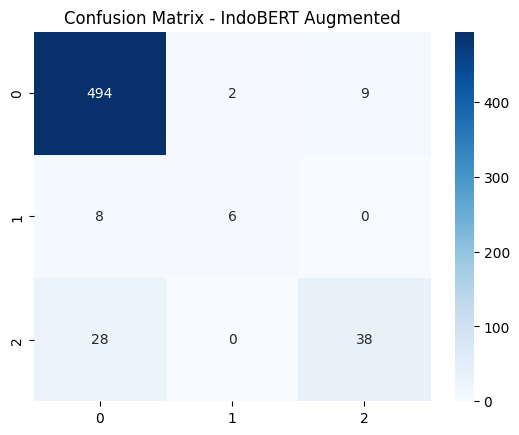

In [13]:
cm = confusion_matrix(trues, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - IndoBERT Augmented")
plt.savefig("confusion_matrix_augmented.png")
plt.show()

test_df_copy = test_df.copy()
test_df_copy['predicted'] = preds
test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
test_df_copy.to_csv("test_predictions_augmented.csv", index=False)


In [14]:
def analyze_per_aspect(test_df, predictions):
    """Analisis detail akurasi per aspek"""
    test_df_copy = test_df.copy()
    test_df_copy['predicted'] = predictions
    test_df_copy['predicted_label'] = test_df_copy['predicted'].map(inv_label_map)
    test_df_copy['true_label'] = test_df_copy['label'].map(inv_label_map)
    test_df_copy['is_correct'] = (test_df_copy['label'] == test_df_copy['predicted'])
    
    print("\n" + "="*80)
    print("ANALISIS AKURASI PER ASPEK")
    print("="*80)
    
    aspek_list = ["aplikasi", "kemudahan", "pembayaran"]
    
    for aspek in aspek_list:
        aspek_df = test_df_copy[test_df_copy['aspect_clean'].str.contains(aspek, na=False)]
        
        if len(aspek_df) == 0:
            continue
            
        correct = aspek_df['is_correct'].sum()
        total = len(aspek_df)
        accuracy = correct / total
        
        print(f"\n{'='*60}")
        print(f">>> ASPEK: {aspek.upper()}")
        print(f"{'='*60}")
        print(f"Total data test: {total}")
        print(f"Prediksi benar: {correct}")
        print(f"Prediksi salah: {total - correct}")
        print(f"Akurasi: {accuracy:.2%}")
        
        # Distribusi label sebenarnya
        print(f"\nDistribusi Label Sebenarnya:")
        print(aspek_df['true_label'].value_counts())
        
        # Distribusi prediksi
        print(f"\nDistribusi Prediksi:")
        print(aspek_df['predicted_label'].value_counts())
        
        # Classification report
        from sklearn.metrics import classification_report
        print(f"\nClassification Report:")
        print(classification_report(
            aspek_df['label'], 
            aspek_df['predicted'],
            target_names=['negatif','netral','positif'],
            zero_division=0
        ))
        
        # Contoh kesalahan prediksi
        wrong_pred = aspek_df[~aspek_df['is_correct']]
        if len(wrong_pred) > 0:
            print(f"\n❌ CONTOH KESALAHAN PREDIKSI (max 5):")
            for idx, row in wrong_pred.head(5).iterrows():
                print(f"\n  • Aspek: {row['aspect']}")
                print(f"    Konteks: {row['context'][:70]}...")
                print(f"    True: {row['true_label']} ➜ Predicted: {row['predicted_label']}")

# Jalankan analisis setelah evaluasi
print("\n" + "="*80)
print("EVALUASI MODEL PER ASPEK")
print("="*80)
analyze_per_aspect(test_df, preds)


EVALUASI MODEL PER ASPEK

ANALISIS AKURASI PER ASPEK

>>> ASPEK: APLIKASI
Total data test: 294
Prediksi benar: 269
Prediksi salah: 25
Akurasi: 91.50%

Distribusi Label Sebenarnya:
true_label
negatif    259
positif     29
netral       6
Name: count, dtype: int64

Distribusi Prediksi:
predicted_label
negatif    278
positif     14
netral       2
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

     negatif       0.92      0.99      0.95       259
      netral       0.50      0.17      0.25         6
     positif       0.86      0.41      0.56        29

    accuracy                           0.91       294
   macro avg       0.76      0.52      0.59       294
weighted avg       0.91      0.91      0.90       294


❌ CONTOH KESALAHAN PREDIKSI (max 5):

  • Aspek: Aplikasi
    Konteks: jadi ga bisa login setelah update...
    True: netral ➜ Predicted: negatif

  • Aspek: Aplikasi
    Konteks: tapi sayang seribu sayang untuk apk terlal

In [15]:
test_df_final = test_df.copy()
test_df_final['predicted'] = preds
test_df_final['predicted_label'] = test_df_final['predicted'].map(inv_label_map)
test_df_final['true_label'] = test_df_final['label'].map(inv_label_map)
test_df_final['is_correct'] = (test_df_final['label'] == test_df_final['predicted'])

# Ekstrak aspek kategori untuk analisis
def extract_aspect_category(aspect_text):
    if 'aplikasi' in aspect_text.lower():
        return 'APLIKASI'
    elif 'kemudahan' in aspect_text.lower() or 'mudah' in aspect_text.lower():
        return 'KEMUDAHAN'
    elif 'pembayaran' in aspect_text.lower() or 'bayar' in aspect_text.lower():
        return 'PEMBAYARAN'
    else:
        return 'LAINNYA'

test_df_final['aspect_category'] = test_df_final['aspect_clean'].apply(extract_aspect_category)

# Simpan hasil lengkap
test_df_final.to_csv("test_predictions_with_aspect_analysis.csv", index=False)

# Simpan hanya kesalahan untuk review
errors_df = test_df_final[~test_df_final['is_correct']]
errors_df.to_csv("test_errors_by_aspect.csv", index=False)

# Summary statistik
print("\n" + "="*80)
print("SUMMARY STATISTIK")
print("="*80)

print("\nAkurasi Per Kategori Aspek:")
for aspect_cat in ['APLIKASI', 'KEMUDAHAN', 'PEMBAYARAN']:
    subset = test_df_final[test_df_final['aspect_category'] == aspect_cat]
    if len(subset) > 0:
        acc = (subset['is_correct'].sum() / len(subset)) * 100
        print(f"  {aspect_cat}: {acc:.2f}% ({subset['is_correct'].sum()}/{len(subset)})")

print("\nTotal Kesalahan Per Aspek:")
error_summary = errors_df.groupby('aspect_category').size()
print(error_summary)

print(f"\n✓ Saved detailed results to: test_predictions_with_aspect_analysis.csv")
print(f"✓ Saved error analysis to: test_errors_by_aspect.csv")
print(f"\nTotal errors: {len(errors_df)}/{len(test_df_final)}")


SUMMARY STATISTIK

Akurasi Per Kategori Aspek:
  APLIKASI: 91.50% (269/294)
  KEMUDAHAN: 92.31% (108/117)
  PEMBAYARAN: 92.53% (161/174)

Total Kesalahan Per Aspek:
aspect_category
APLIKASI      25
KEMUDAHAN      9
PEMBAYARAN    13
dtype: int64

✓ Saved detailed results to: test_predictions_with_aspect_analysis.csv
✓ Saved error analysis to: test_errors_by_aspect.csv

Total errors: 47/585
